<a href="https://colab.research.google.com/github/Schimidel/UGRH-s-PrecipitacaoeTemperatura/blob/main/Dados_CESMLENS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# instalando tudo que precisamos (essa operação demora um pouco)
%%capture
!pip install s3fs          # módulo para montar buckets do AWS
!pip install Intake-esm    # usamos isso para "vasculhar" o que tem na nuvem

!pip install -U xarray[complete] # reinstala todo o xarray (útil nessa versão do colab por conta do cftime)

!pip install salem  # e também com o salem e o rasterio
!pip install rasterio

!pip install cartopy # porque queremos fazer mapas legais.
!pip install pandas>=2.1.0 # uma pequena atualização
# provavelmente o seu runtime irá reiniciar. Não tem problema ! É normal isso acontecer.
# o sistema irá reiniciar (note que a célula vai peder a barrinha verde)

In [ ]:
import geopandas as gpd
import requests
import intake
import xarray
import matplotlib.pyplot as plt
import salem
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# URL do arquivo ZIP
url = "https://github.com/andrebelem/pythonverse/raw/main/datasets/SNIRH_UGRHs_2020.zip"

# Nome do arquivo local para salvar
nome_arquivo = "SNIRH_UGRHs_2020.zip"

# Faz o download do arquivo
response = requests.get(url)

# Verifica se a requisição foi bem-sucedida (código 200)
if response.status_code == 200:
    # Abre o arquivo local em modo de escrita em bytes
    with open(nome_arquivo, "wb") as f:
        # Escreve os dados no arquivo
        f.write(response.content)
    print("Download concluído com sucesso!")

Download concluído com sucesso!


In [ ]:
gdf = gpd.read_file("SNIRH_UGRHs_2020.zip")

# Filtrar a bacia desejada (exemplo usando o Paraná)
parana = gdf[gdf.NOME == "Paraná"]

In [ ]:
# agora vamos listar tudo que existe no cesm-lens (no S3 AWS Bucket). Notem que tudo isso está na nuvem
import intake
col = intake.open_esm_datastore("https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json") # este é outro conjunto de dados

In [ ]:
# o contudo do bucket está em um dataframe, e é visualizado abaixo.
col.df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,FLNS,net longwave flux at surface,atm,historical,cmip6,daily,1.0,global,W/m2,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
1,FLNSC,clearsky net longwave flux at surface,atm,historical,cmip6,daily,1.0,global,W/m2,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
2,FLUT,upwelling longwave flux at top of model,atm,historical,cmip6,daily,1.0,global,W/m2,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
3,FSNS,net solar flux at surface,atm,historical,cmip6,daily,1.0,global,W/m2,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
4,FSNSC,clearsky net solar flux at surface,atm,historical,cmip6,daily,1.0,global,W/m2,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
...,...,...,...,...,...,...,...,...,...,...,...,...
317,WVEL,vertical velocity,ocn,ssp370,smbb,monthly,60.0,global_ocean,centimeter/s,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/ocn/monthly/cesm2LE-ssp37...
318,NaN,NaN,ocn,historical,smbb,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm2-lens/ocn/static/grid.zarr
319,NaN,NaN,ocn,historical,cmip6,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm2-lens/ocn/static/grid.zarr
320,NaN,NaN,ocn,ssp370,smbb,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm2-lens/ocn/static/grid.zarr


In [ ]:
# estou interessado (por exemplo, na variável que contém a "taxa de precipitação")
col_df = col.df
col_df = col_df.fillna('desconhecido')
col_df[col_df.long_name.str.contains('temperature')]

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
14,T,temperature,atm,historical,cmip6,daily,32.0,global,K,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
16,TREFHT,reference height temperature,atm,historical,cmip6,daily,1.0,global,K,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
17,TREFHTMN,minimum reference height temperature over outp...,atm,historical,cmip6,daily,1.0,global,K,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
18,TREFHTMX,maximum reference height temperature over outp...,atm,historical,cmip6,daily,1.0,global,K,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
19,TS,surface temperature (radiative),atm,historical,cmip6,daily,1.0,global,K,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
...,...,...,...,...,...,...,...,...,...,...,...,...
264,SNOW,"atmospheric snow, after rain/snow repartitioni...",lnd,ssp370,smbb,monthly,1.0,global_land,mm/s,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/lnd/monthly/cesm2LE-ssp37...
267,TREFMXAV,daily maximum of average 2-m temperature,lnd,ssp370,smbb,monthly,1.0,global_land,K,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/lnd/monthly/cesm2LE-ssp37...
271,TEMP,potential temperature,ocn,historical,cmip6,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,2014-12-16 12:00:00,s3://ncar-cesm2-lens/ocn/monthly/cesm2LE-histo...
293,TEMP,potential temperature,ocn,ssp370,cmip6,monthly,60.0,global_ocean,degC,2015-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm2-lens/ocn/monthly/cesm2LE-ssp37...


In [ ]:
col_df.loc[col_df.variable.str.contains("PREC")]

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
6,PRECC,convective precipitation rate (liq + ice),atm,historical,cmip6,daily,1.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
7,PRECL,large-scale (stable) precipitation rate (liq +...,atm,historical,cmip6,daily,1.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
8,PRECSC,convective snow rate (water equivalent),atm,historical,cmip6,daily,1.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
9,PRECSL,large-scale (stable) snow rate (water equivalent),atm,historical,cmip6,daily,1.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
29,PRECC,convective precipitation rate (liq + ice),atm,historical,smbb,daily,1.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
30,PRECL,large-scale (stable) precipitation rate (liq +...,atm,historical,smbb,daily,1.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
31,PRECSC,convective snow rate (water equivalent),atm,historical,smbb,daily,1.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
32,PRECSL,large-scale (stable) snow rate (water equivalent),atm,historical,smbb,daily,1.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
52,PRECC,convective precipitation rate (liq + ice),atm,ssp370,cmip6,daily,1.0,global,m/s,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-...
53,PRECL,large-scale (stable) precipitation rate (liq +...,atm,ssp370,cmip6,daily,1.0,global,m/s,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-...


In [ ]:
# vou fazer um subset onde separo apenas o que eu quero, frequẽncia diária
col_subset = col.search(experiment=["historical","ssp370"], frequency="monthly", variable=["PRECC", "PRECL", "T"], forcing_variant='cmip6')

In [ ]:
# agora vou criar datasets do meu subset
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [ ]:
dsets.keys() # podemos verificar se ele contém o que precisamos aqui.

dict_keys(['atm.historical.monthly.cmip6', 'atm.ssp370.monthly.cmip6'])

In [ ]:
ds1 = dsets['atm.historical.monthly.cmip6']
ds2 = dsets['atm.ssp370.monthly.cmip6']

In [ ]:
ds1

<xarray.Dataset> Size: 745GB
Dimensions:    (member_id: 50, time: 1980, lat: 192, lon: 288, nbnd: 2, lev: 32)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, nbnd) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * lev        (lev) float64 256B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
Dimensions without coordinates: nbnd
Data variables:
    PRECC      (member_id, time, lat, lon) float32 22GB dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
    PRECL      (member_id, time, lat, lon) float32 22GB dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
    T          (member_id, time, lev, lat, lon) float32 701GB dask.array<chunksize=(1, 24, 32, 192, 288), meta=np.ndarray>
Attributes: (12/16)
    Conventions:                       CF-1.0
    NCO:                               netCDF Operators version 4.9.4 (Homepa...
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CAM
    time_period_freq:                  month_1
    ...                                ...
    intake_esm_attrs:frequency:        monthly
    intake_esm_attrs:spatial_domain:   global
    intake_esm_attrs:start_time:       1850-01-16 12:00:00
    intake_esm_attrs:end_time:         2014-12-16 12:00:00
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.historical.monthly.cmip6

In [ ]:
import xarray as xr
ds_CESM = xr.concat([ds1, ds2], dim="time")
ds_CESM = ds_CESM.sel(lev=1000, method='nearest')
#ds_CESM = ds_CESM.mean(dim='member_id')

In [ ]:
#Converte o grid de 0x360 lon para -180x180
ds_CESM.coords['lon'] = (ds_CESM.coords['lon'] + 180) % 360 - 180
ds_CESM = ds_CESM.sortby(ds_CESM.lon)

In [ ]:
#ds_CESM = ds_CESM.isel(member_id=0)

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon

# Obter os limites do polígono (vértices extremos)
bounds = parana.geometry.bounds

# Extrair coordenadas dos limites
min_x, min_y, max_x, max_y = bounds.minx.min(), bounds.miny.min(), bounds.maxx.max(), bounds.maxy.max()

# Criar um quadrado com base nos limites
quadrado = Polygon([(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)])

# Criar um GeoDataFrame para o quadrado
quadrado_gdf = gpd.GeoDataFrame(geometry=[quadrado], crs=parana.crs)


In [ ]:
CESM_sel_prec = ds_CESM[['PRECC', 'PRECL']].salem.subset(shape=quadrado_gdf)
CESM_sel_T = ds_CESM['T'].salem.subset(shape=quadrado_gdf)

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


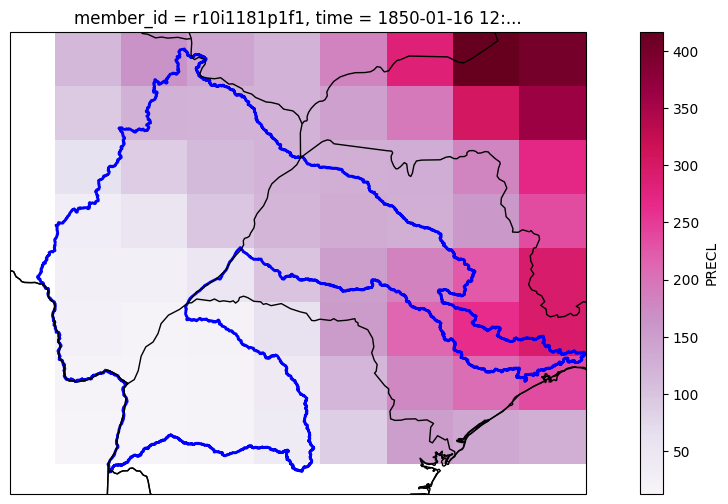

In [ ]:
# vou fazer um plot "decente" de um dia qualquer com o semiárido
# note que copiei o código lá de cima

import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
(CESM_sel_prec['PRECL'] * 1000* 24 * 30 * 60 * 60).isel(time=0, member_id=0).plot(ax=ax,
            transform=ccrs.PlateCarree(), x='lon', y='lat',
            cmap='PuRd', # altere os valores de vmax para ver o que acontece
            add_colorbar=True)

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_lines')
contries = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_0_countries')

ax.add_feature(states, facecolor='none', edgecolor='black')
ax.add_feature(contries, facecolor='none', edgecolor='black')

parana.geometry.plot(ax=ax,facecolor='none',edgecolor='blue',linewidth=2)

ax.coastlines()

<ipython-input-27-2905779000>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parana_exp = parana.buffer(0.5)


<Axes: >

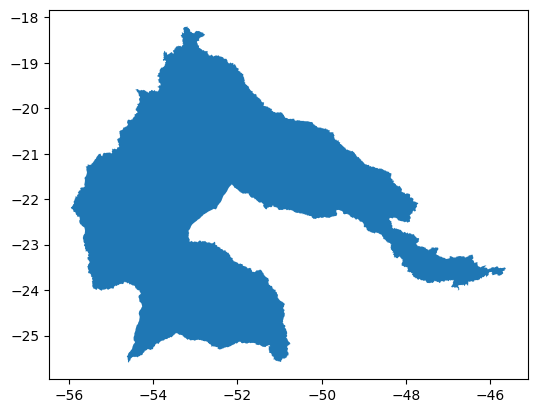

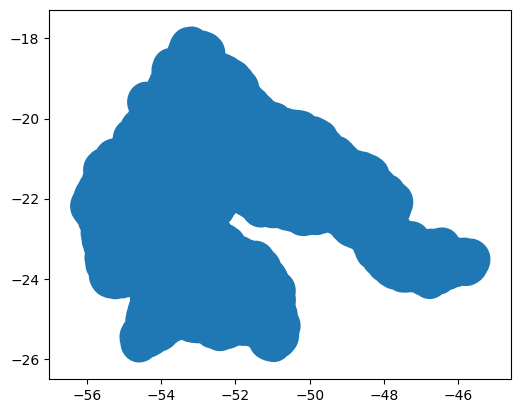

In [ ]:
# Supondo que 'shapefile' seja o seu shapefile
parana_exp = parana.buffer(0.5)

# Supondo que 'parana_exp' seja seu GeoSeries
parana_exp = gpd.GeoDataFrame(geometry=parana_exp)
parana_exp.crs = parana.crs  # Atribua o mesmo CRS do GeoDataFrame original 'parana'

parana.plot()
parana_exp.plot()

In [ ]:
precip_CESM = CESM_sel_prec.salem.roi(shape=parana_exp)
temp_CESM =  CESM_sel_T.salem.roi(shape=parana_exp) # essa operação pode demorar um pouco dependendo do tamanho dos seus dados

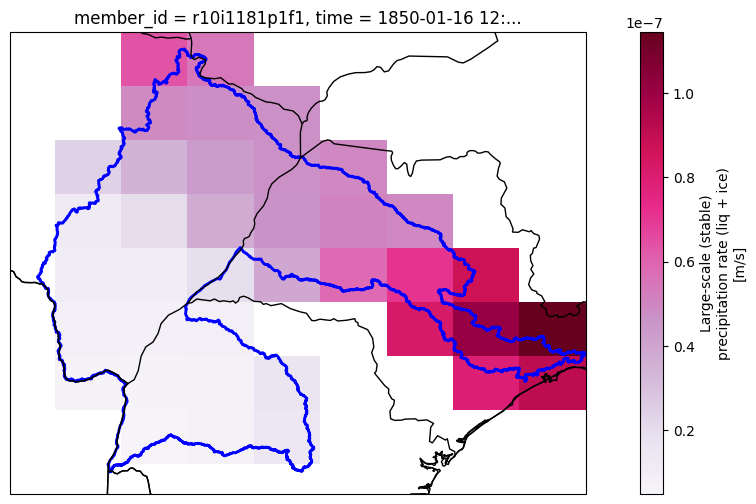

In [ ]:
# vou fazer um plot "decente" de um dia qualquer com o semiárido
# note que copiei o código lá de cima

import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
precip_CESM['PRECL'].isel(time=0, member_id=0).plot(ax=ax,
            transform=ccrs.PlateCarree(), x='lon', y='lat',
            cmap='PuRd', # altere os valores de vmax para ver o que acontece
            add_colorbar=True)

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_lines')
contries = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_0_countries')

ax.add_feature(states, facecolor='none', edgecolor='black')
ax.add_feature(contries, facecolor='none', edgecolor='black')

parana.geometry.plot(ax=ax,facecolor='none',edgecolor='blue',linewidth=2)

ax.coastlines()

In [ ]:
#Seleciona o período do CESM
precip_CESM = precip_CESM.sel(time=slice("1974", "2024"))
temp_CESM = temp_CESM.sel(time=slice("1974", "2024"))

In [ ]:
precip_CESM['PRECT'] = precip_CESM['PRECC'] + precip_CESM['PRECL']

In [ ]:
#Faz a série temporal para região
mean_prec = precip_CESM['PRECT'].mean(dim=["lat", "lon", "member_id"])
mean_temp = temp_CESM.mean(dim=["lat", "lon", "member_id"])

In [ ]:
#Transforma as variáveis
mean_prec = mean_prec * 1000 * 24 * 60 * 60 * 30 #m/s --> mm/mês
mean_temp = mean_temp - 273.15 #Kelvin --> °C

In [ ]:
mean_prec = mean_prec.sel(time=slice("1974", "2024"))
mean_temp = mean_temp.sel(time=slice("1974", "2024"))

In [ ]:
# Salvando o DataFrame em um arquivo CSV
mean_prec.to_netcdf("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/Media_precip_CESMLENS.nc")
mean_temp.to_netcdf("/content/drive/MyDrive/Artigo_ABRHIDRO_Mudanças_Climáticas/Dados/Media_temp_CESMLENS.nc")